In [83]:
#https://www.jeremyjordan.me/nn-learning-rate/

#https://mancap314.github.io/cyclical-learning-rates-with-tensorflow-implementation.html

In [2]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

In [3]:
import numpy as np

In [173]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LeakyReLU, ReLU, ELU
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay, InverseTimeDecay
from tensorflow.keras.layers import BatchNormalization


from tensorflow.keras.initializers import glorot_normal, he_uniform

In [5]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D

In [6]:
from tensorflow.keras.layers import Conv2D

In [7]:
from tensorflow.keras.layers import Flatten

In [8]:
from tqdm.keras import TqdmCallback

Using TensorFlow backend.


In [9]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [10]:
# from scrinet.fits import nn

In [11]:
from scrinet.fits import scale

In [12]:
Xy = np.loadtxt("./data_to_fit.txt")
# sort by X
X_raw, y_raw = Xy[np.argsort(Xy[:, 0])].T

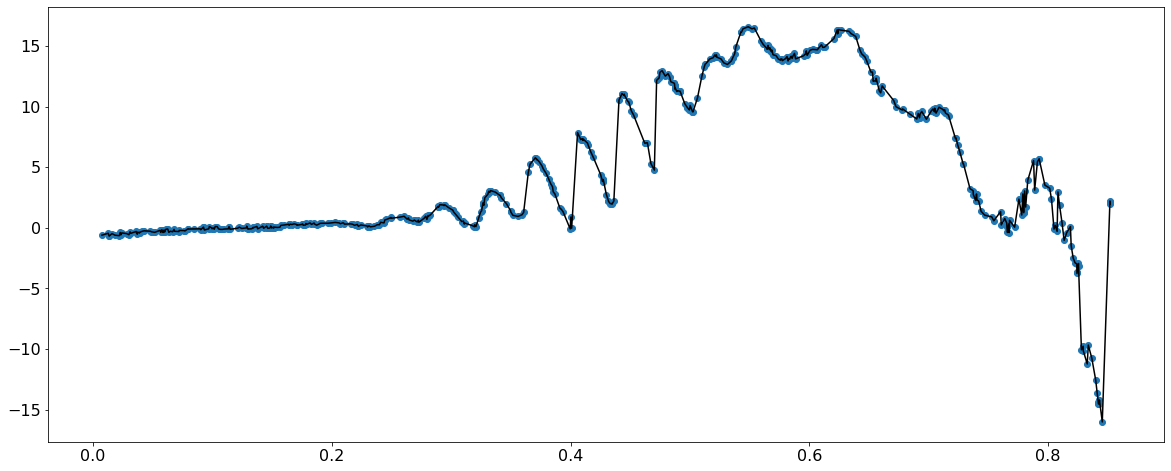

In [13]:
plt.figure(figsize=(20,8))
plt.scatter(X_raw,y_raw)
plt.plot(X_raw, y_raw, c='k')

In [14]:
# lets interpolat and resample

In [15]:
def resample_data(X, y, xmin=None, xmax=None, npts=1000, k=1):
    
    if xmin is None:
        xmin = X[0]
    if xmax is None:
        xmax = X[-1]
    mask = (X>=xmin) & (X<=xmax)
    
    iy = IUS(X[mask], y[mask], k=k)
    
    Xnew = np.linspace(xmin, xmax, npts)
    
    return Xnew, iy(Xnew)

In [16]:
# X, y = resample_data(X_raw, y_raw, xmin=0.4, xmax=0.45, npts=100, k=1)
X, y = resample_data(X_raw, y_raw)
# X, y = X_raw, y_raw

In [17]:
X.shape

(1000,)

In [18]:
y.shape

(1000,)

In [19]:
# mask = (X > 0.3) & (X < 0.4)
# # mask = None
# if mask is not None:
#     X = X[mask]
#     y = y[mask]

In [20]:
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

In [21]:
scaleX=True
scaleY=True
if scaleX:
    X = X.copy()
    X_scalers = scale.make_scalers(X)
    X = scale.apply_scaler(X, X_scalers)
if scaleY:
    y = y.copy()
    Y_scalers = scale.make_scalers(y)
    y = scale.apply_scaler(y, Y_scalers)

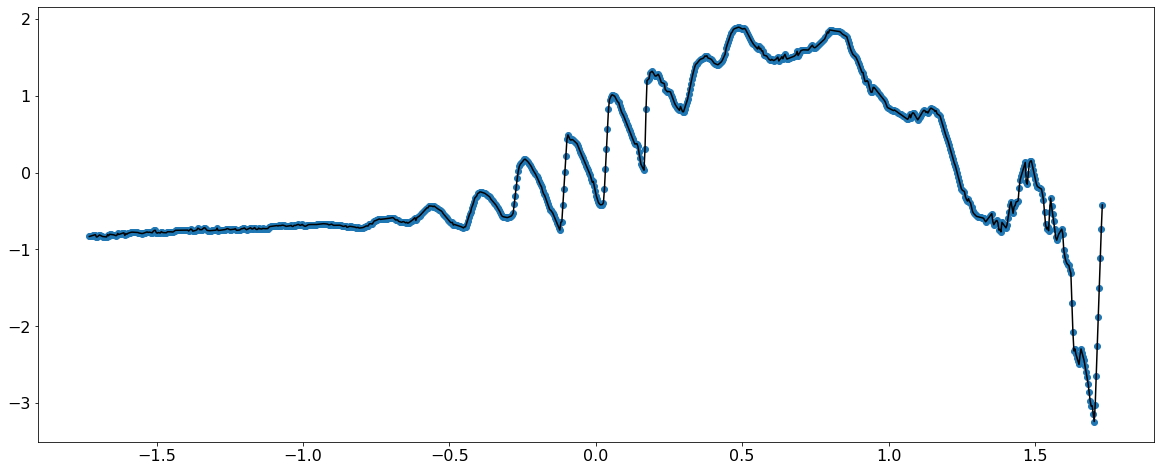

In [22]:
plt.figure(figsize=(20,8))
plt.scatter(X,y)
plt.plot(X, y, c='k')

# fitting

In [273]:
from tensorflow.keras.callbacks import LearningRateScheduler

def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
    return LearningRateScheduler(schedule)

lr_sched = step_decay_schedule(initial_lr=1e-4, decay_factor=0.75, step_size=2)

In [433]:
epochs_array = np.linspace(1, 5000, 1000)

In [453]:
lr_sched = step_decay_schedule(initial_lr=1e-3, decay_factor=0.3, step_size=1000)

(1e-10, 0.11220184543019636)

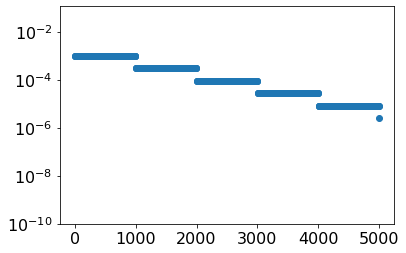

In [455]:
plt.figure()
plt.scatter(epochs_array, lr_sched.schedule(epochs_array))
plt.yscale('log')
plt.ylim(1e-10)

In [456]:
input_dim = X.shape[1]
noutput = y.shape[1]

epochs=5000
input_units=128
units=[128,128,128]
# units=[128,128]
# activation='relu'
activation=LeakyReLU(alpha=0.3)


# kernel_initializer = 'he_uniform'
# kernel_initializer = 'glorot_uniform'

# Initializers set for better reproducibility
seed = 1
# glorot_initializer = glorot_normal(seed=seed)
he_initializer = he_uniform(seed=seed)

kernel_initializer = he_initializer


batch_size=40
learning_rate=1e-3
# optimizer = Adam(learning_rate=learning_rate)
# optimizer = tf.keras.optimizers.Adadelta()
# optimizer = tf.keras.optimizers.Adagrad()
# optimizer = tf.keras.optimizers.Nadam()
# optimizer = tf.keras.optimizers.Adamax()
# optimizer = tf.keras.optimizers.RMSprop()
# optimizer = tf.keras.optimizers.Ftrl()
optimizer = tf.keras.optimizers.Adam()

In [458]:
model = Sequential()
model.add(
    Dense(input_units, activation=activation, input_dim=input_dim, kernel_initializer=kernel_initializer)
)
for i in range(len(units)):
    model.add(
        Dense(units=units[i], activation=activation, kernel_initializer=kernel_initializer, use_bias=True)
    )
#     model.add(BatchNormalization())
model.add(Dense(noutput, activation='linear'))
model.compile(optimizer=optimizer, loss = 'mean_squared_error', metrics=['mse','mae'])
callbacks=[]
callbacks=[TqdmCallback(verbose=1)]
if lr_sched:
    callbacks.append(lr_sched)
history = model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=callbacks)

In [459]:
history.history.keys()

dict_keys(['loss', 'mse', 'mae', 'lr'])

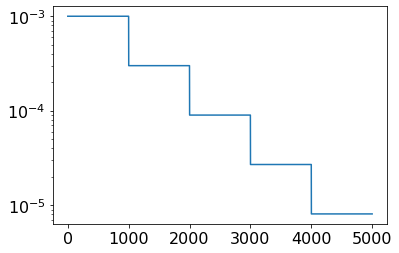

In [460]:
plt.figure()
plt.plot(history.history['lr'])
plt.yscale('log')

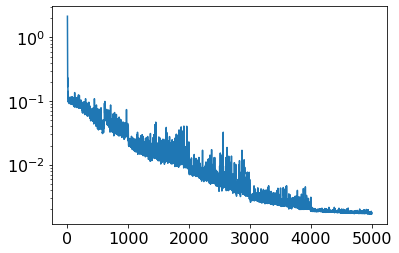

In [461]:
plt.figure()
plt.plot(history.history['loss'])
plt.yscale('log')

In [462]:
yhat = model.predict(X)

x_extrap = np.linspace(X[0], X[-1], 1000).reshape(-1,1)
y_extrap = model.predict(x_extrap)

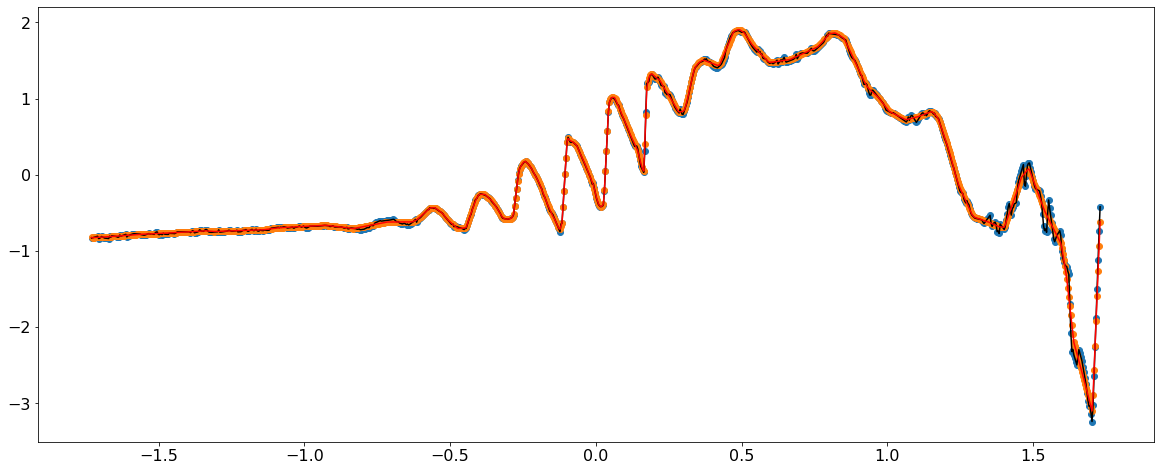

In [463]:
plt.figure(figsize=(20,8))
plt.scatter(X, y)
plt.plot(X, y, c='k')

plt.scatter(X, yhat)

plt.plot(x_extrap, y_extrap, c='r')

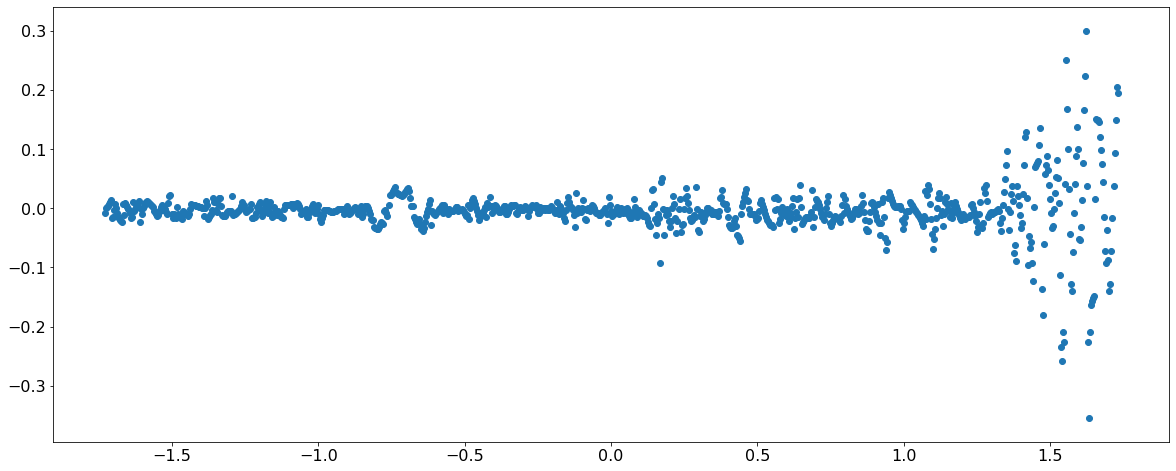

In [464]:
plt.figure(figsize=(20,8))
plt.scatter(X, y-yhat)

(1e-05, 1.1220184543019633)

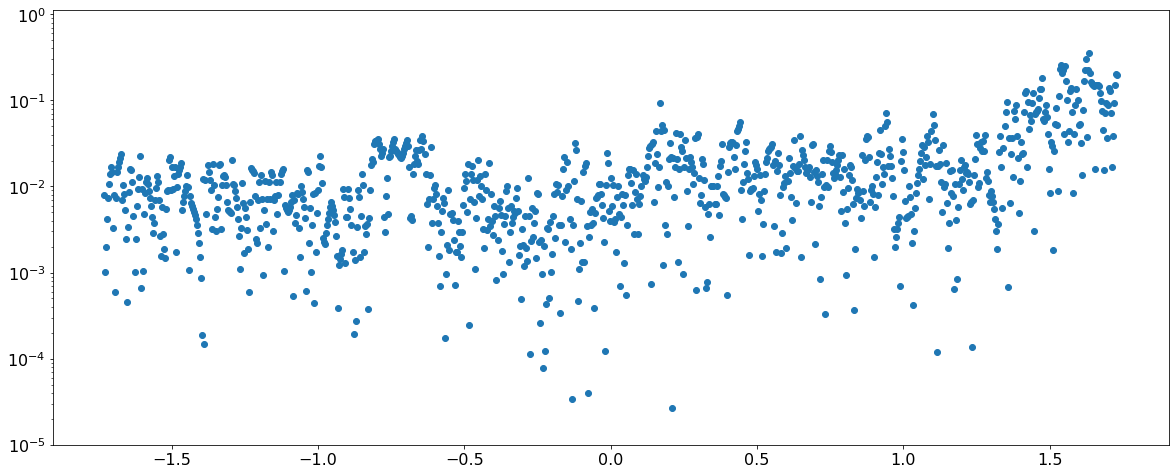

In [465]:
plt.figure(figsize=(20,8))
plt.scatter(X, np.abs(y-yhat))
plt.yscale('log')
plt.ylim(1e-5)